# Lab : Cardiac Dataset on MLLib

### Overview
Analyze some medical data using NNFrames on Analytics ZOo

### Runtime
30 mins

## Step 1 -About Data

[About data](https://archive.ics.uci.edu/ml/datasets/heart+Disease)

This is a classification dataset, based on inputs  we predict the `target`

Sample Data:
```text
age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0

```

## Step 2 - Init

In [1]:
import zoo
from zoo.common.nncontext import init_nncontext

sc = init_nncontext("Cardiac")
print("zoo version : ", zoo.__version__)

## Spark UI
print('Spark UI running on http://localhost:' + sc.uiWebUrl.split(':')[2])
sc

zoo version :  0.6.0.dev0
Spark UI running on http://localhost:4041


<SparkContext master=local[*] appName=PySparkShell>

## Step 3 - Explore Dataset

### 3.1 - Load Data

In [2]:
!wget 'https://elephantscale-public.s3.amazonaws.com/data/heart/heart.csv'

--2019-11-01 19:55:36--  https://elephantscale-public.s3.amazonaws.com/data/heart/heart.csv
Resolving elephantscale-public.s3.amazonaws.com (elephantscale-public.s3.amazonaws.com)... 52.216.186.75
Connecting to elephantscale-public.s3.amazonaws.com (elephantscale-public.s3.amazonaws.com)|52.216.186.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13273 (13K) [text/csv]
Saving to: ‘heart.csv.1’

heart.csv.1         100%[===================>]  12.96K  --.-KB/s    in 0.001s  

2019-11-01 19:55:36 (19.5 MB/s) - ‘heart.csv.1’ saved [13273/13273]



In [3]:

data = spark.read.csv("heart.csv", \
                      header=True, inferSchema=True)
print("record count ", data.count())
data = data.na.drop()
print ("clean data count ", data.count())
data.printSchema()
data.show()

record count  303
clean data count  303
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- target: integer (nullable = true)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----------+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|      thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----------+------+
| 63|  1|  1|     145| 233|  1|      2|    150|    0|    2.3|    3|  0|     fixed|     0|
| 67|  1|  4|     160| 286|  0|      2|    108|    1|    1.5|    2| 

### 3.2 - Basic Exploration

In [4]:
data.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,303,54.59405940594059,9.01637019425794,29,77
sex,303,0.6765676567656765,0.4685599693856874,0,1
cp,303,3.108910891089109,1.0284141018485655,0,4
trestbps,303,131.78547854785478,17.748337866922796,94,200
chol,303,246.54785478547853,52.175933152649066,126,564
fbs,303,0.1485148514851485,0.3561978749279765,0,1
restecg,303,0.9900990099009901,0.9882928907194963,0,2
thalach,303,149.1947194719472,23.17336844604762,71,202
exang,303,0.32673267326732675,0.4697944645223164,0,1


In [5]:
data.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|   83|
|     0|  220|
+------+-----+



### 3.3 - Graph

   target  count
0       1     83
1       0    220


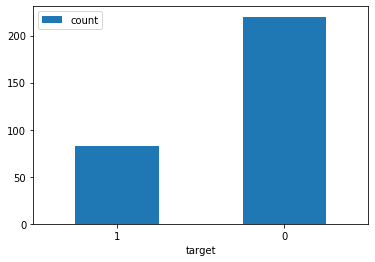

In [6]:
## basic frequency graph

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

a = data.groupBy("target").count().toPandas()
print(a)
a = a.set_index('target')
a.plot(kind='bar', rot=0)
plt.show()

## Step 4 - Create Feature Vectors

### 4.1 - No zeroes in Target Label column

In [7]:
# Analyitics-Zoo prefers no 0 (zero) in label column
# so we will to add +1 to label
data = data.withColumn("target2", data['target']+1)
data.groupBy("target2").count().show()
data.show(10)

+-------+-----+
|target2|count|
+-------+-----+
|      1|  220|
|      2|   83|
+-------+-----+

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----------+------+-------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|      thal|target|target2|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----------+------+-------+
| 63|  1|  1|     145| 233|  1|      2|    150|    0|    2.3|    3|  0|     fixed|     0|      1|
| 67|  1|  4|     160| 286|  0|      2|    108|    1|    1.5|    2|  3|    normal|     1|      2|
| 67|  1|  4|     120| 229|  0|      2|    129|    1|    2.6|    2|  2|reversible|     0|      1|
| 37|  1|  3|     130| 250|  0|      0|    187|    0|    3.5|    3|  0|    normal|     0|      1|
| 41|  0|  2|     130| 204|  0|      2|    172|    0|    1.4|    1|  0|    normal|     0|      1|
| 56|  1|  2|     120| 236|  0|      0|    178|    0|    0.8|    1|  0|    normal|     0|      1|
| 62|  0|  4|     140

### Convert Categorical Columns

Here we are going to convert categorical columns using the StringIndexer class.


In [8]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="thal", outputCol="thalIndex")
data = indexer.fit(data).transform(data)

### Select Columns of Interest

Now let's select columms of interest:

1. Age
2. Sex
3. trestbps
4. chol
5. thalach
6. oldpeak
7. slope
8. ca
9. thalIndex (the converted thal column from the last step)



In [9]:
feature_columns = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca', 'thalIndex']
target_columns = ['target2']

data = data.select(feature_columns + target_columns)
data.show()

+---+---+--------+----+-------+-------+-----+---+---------+-------+
|age|sex|trestbps|chol|thalach|oldpeak|slope| ca|thalIndex|target2|
+---+---+--------+----+-------+-------+-----+---+---------+-------+
| 63|  1|     145| 233|    150|    2.3|    3|  0|      2.0|      1|
| 67|  1|     160| 286|    108|    1.5|    2|  3|      0.0|      2|
| 67|  1|     120| 229|    129|    2.6|    2|  2|      1.0|      1|
| 37|  1|     130| 250|    187|    3.5|    3|  0|      0.0|      1|
| 41|  0|     130| 204|    172|    1.4|    1|  0|      0.0|      1|
| 56|  1|     120| 236|    178|    0.8|    1|  0|      0.0|      1|
| 62|  0|     140| 268|    160|    3.6|    3|  2|      0.0|      2|
| 57|  0|     120| 354|    163|    0.6|    1|  0|      0.0|      1|
| 63|  1|     130| 254|    147|    1.4|    2|  1|      1.0|      2|
| 53|  1|     140| 203|    155|    3.1|    3|  0|      1.0|      1|
| 57|  1|     140| 192|    148|    0.4|    2|  0|      2.0|      1|
| 56|  0|     140| 294|    153|    1.3|    2|  0

### 4.2 - Convert to Double
Analytics Zoo likes all numbers in Double

In [10]:
from pyspark.sql.functions import col, udf
# convert everything to double
data = data.select([col(c).cast("double") for c in data.columns])
data.printSchema()
data.show(5)

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thalIndex: double (nullable = false)
 |-- target2: double (nullable = true)

+----+---+--------+-----+-------+-------+-----+---+---------+-------+
| age|sex|trestbps| chol|thalach|oldpeak|slope| ca|thalIndex|target2|
+----+---+--------+-----+-------+-------+-----+---+---------+-------+
|63.0|1.0|   145.0|233.0|  150.0|    2.3|  3.0|0.0|      2.0|    1.0|
|67.0|1.0|   160.0|286.0|  108.0|    1.5|  2.0|3.0|      0.0|    2.0|
|67.0|1.0|   120.0|229.0|  129.0|    2.6|  2.0|2.0|      1.0|    1.0|
|37.0|1.0|   130.0|250.0|  187.0|    3.5|  3.0|0.0|      0.0|    1.0|
|41.0|0.0|   130.0|204.0|  172.0|    1.4|  1.0|0.0|      0.0|    1.0|
+----+---+--------+-----+-------+-------+-----+---+-------

### 4.3 - Feature Vector

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

assembler = VectorAssembler (inputCols=feature_columns, outputCol='assembled')
fv = assembler.transform(data)
fv = fv.withColumn ('label', fv['target2'])
fv.show(5)

+----+---+--------+-----+-------+-------+-----+---+---------+-------+--------------------+-----+
| age|sex|trestbps| chol|thalach|oldpeak|slope| ca|thalIndex|target2|           assembled|label|
+----+---+--------+-----+-------+-------+-----+---+---------+-------+--------------------+-----+
|63.0|1.0|   145.0|233.0|  150.0|    2.3|  3.0|0.0|      2.0|    1.0|[63.0,1.0,145.0,2...|  1.0|
|67.0|1.0|   160.0|286.0|  108.0|    1.5|  2.0|3.0|      0.0|    2.0|[67.0,1.0,160.0,2...|  2.0|
|67.0|1.0|   120.0|229.0|  129.0|    2.6|  2.0|2.0|      1.0|    1.0|[67.0,1.0,120.0,2...|  1.0|
|37.0|1.0|   130.0|250.0|  187.0|    3.5|  3.0|0.0|      0.0|    1.0|[37.0,1.0,130.0,2...|  1.0|
|41.0|0.0|   130.0|204.0|  172.0|    1.4|  1.0|0.0|      0.0|    1.0|[41.0,0.0,130.0,2...|  1.0|
+----+---+--------+-----+-------+-------+-----+---+---------+-------+--------------------+-----+
only showing top 5 rows



### 4.4 - Scaling

In [13]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler (inputCol="assembled", outputCol="features")
fv = scaler.fit(fv).transform(fv)
fv.show(5)

+----+---+--------+-----+-------+-------+-----+---+---------+-------+--------------------+-----+--------------------+
| age|sex|trestbps| chol|thalach|oldpeak|slope| ca|thalIndex|target2|           assembled|label|              scaled|
+----+---+--------+-----+-------+-------+-----+---+---------+-------+--------------------+-----+--------------------+
|63.0|1.0|   145.0|233.0|  150.0|    2.3|  3.0|0.0|      2.0|    1.0|[63.0,1.0,145.0,2...|  1.0|[6.98729074368768...|
|67.0|1.0|   160.0|286.0|  108.0|    1.5|  2.0|3.0|      0.0|    2.0|[67.0,1.0,160.0,2...|  2.0|[7.43092825122340...|
|67.0|1.0|   120.0|229.0|  129.0|    2.6|  2.0|2.0|      1.0|    1.0|[67.0,1.0,120.0,2...|  1.0|[7.43092825122340...|
|37.0|1.0|   130.0|250.0|  187.0|    3.5|  3.0|0.0|      0.0|    1.0|[37.0,1.0,130.0,2...|  1.0|[4.10364694470546...|
|41.0|0.0|   130.0|204.0|  172.0|    1.4|  1.0|0.0|      0.0|    1.0|[41.0,0.0,130.0,2...|  1.0|[4.54728445224119...|
+----+---+--------+-----+-------+-------+-----+---+-----

In [15]:

fv.printSchema()
fv.limit(5).toPandas()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thalIndex: double (nullable = false)
 |-- target2: double (nullable = true)
 |-- assembled: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- scaled: vector (nullable = true)
 |-- features: vector (nullable = true)



,age,sex,trestbps,chol,thalach,oldpeak,slope,ca,thalIndex,target2,assembled,label,scaled,features
0,63.0,1.0,145.0,233.0,150.0,2.3,3.0,0.0,2.0,1.0,"[63.0, 1.0, 145.0, 233.0, 150.0, 2.3, 3.0, 0.0...",1.0,"[6.987290743687681, 2.1341985345249728, 8.1697...","[6.987290743687681, 2.1341985345249728, 8.1697..."
1,67.0,1.0,160.0,286.0,108.0,1.5,2.0,3.0,0.0,2.0,"[67.0, 1.0, 160.0, 286.0, 108.0, 1.5, 2.0, 3.0...",2.0,"[7.430928251223407, 2.1341985345249728, 9.0149...","[7.430928251223407, 2.1341985345249728, 9.0149..."
2,67.0,1.0,120.0,229.0,129.0,2.6,2.0,2.0,1.0,1.0,"[67.0, 1.0, 120.0, 229.0, 129.0, 2.6, 2.0, 2.0...",1.0,"[7.430928251223407, 2.1341985345249728, 6.7611...","[7.430928251223407, 2.1341985345249728, 6.7611..."
3,37.0,1.0,130.0,250.0,187.0,3.5,3.0,0.0,0.0,1.0,"[37.0, 1.0, 130.0, 250.0, 187.0, 3.5, 3.0, 0.0...",1.0,"[4.1036469447054635, 2.1341985345249728, 7.324...","[4.1036469447054635, 2.1341985345249728, 7.324..."
4,41.0,0.0,130.0,204.0,172.0,1.4,1.0,0.0,0.0,1.0,"[41.0, 0.0, 130.0, 204.0, 172.0, 1.4, 1.0, 0.0...",1.0,"[4.54728445224119, 0.0, 7.324629549805802, 3.9...","[4.54728445224119, 0.0, 7.324629549805802, 3.9..."


## Step 5 - Split training / validation

In [16]:
(training, validation) = fv.randomSplit([0.7,0.3])
print("training set count ", training.count())
print("validation set count ", validation.count())

training set count  207
validation set count  96


## Step 6 - Design Network

### 6.1 - Designing the network
Here's a picture of a simple neural network, like what we have in this example:



As you can see, we have a total of 3 layers:

1. Input layer (sized as number of features -- in this case 9 : 'a' -- 'h')
2. Hidden Layer (size we have to specify as part of the model).
3. Output Layer (Number of output classes we are trying to classify -- in this case 2)

## Step  7 -  Create the Network

### 7.1 - Network Parameters

In [21]:
learning_rate = 0.001
training_epochs = 100
# batch size should be multiple of number of cores.
# So powers of two is a good bet
batch_size = 16

# Network Parameters
n_input = len(feature_columns)
n_classes=2
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128  # 2nd layer number of neurons

### 7.2 - setup network

In [22]:
from bigdl.nn.layer import Sequential, Linear, LogSoftMax
from bigdl.nn.criterion import ClassNLLCriterion
from zoo.pipeline.nnframes import  NNClassifier
from bigdl.optim.optimizer import Adam, SGD, Adagrad

## 4 layers = input [8] + first hidden [5]  + second hind layer [3] + output [2]
nn = Sequential().add(Linear(n_input, n_hidden_1)).\
                  add(Linear(n_hidden_1, n_hidden_2)).\
                  add(Linear(n_hidden_2, n_classes)).\
                  add(LogSoftMax())

estimator = NNClassifier(nn, ClassNLLCriterion(), [n_input])

estimator.setMaxEpoch(training_epochs)\
            .setBatchSize(batch_size)\
            .setLearningRate(learning_rate)

estimator.setLabelCol("label").setFeaturesCol("features")

# optimizer method, default is SGD
estimator.setOptimMethod(Adam())

print ("nn \n", nn)

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam
nn 
 Sequential[8e1a55c]{
  [input -> (1) -> (2) -> (3) -> (4) -> output]
  (1): Linear[68bb4ab3](9 -> 128)
  (2): Linear[2262e234](128 -> 128)
  (3): Linear[6d730170](128 -> 2)
  (4): LogSoftMax[187fba15]
}


## Step 8 - Train / Predict

### 8.1 - Train

In [23]:
%%time 

## training
print ("starting training...")
model = estimator.fit(training)
print("initial model training finished.")

starting training...
creating: createToTuple
creating: createChainedPreprocessing
initial model training finished.
CPU times: user 12.7 ms, sys: 624 µs, total: 13.4 ms
Wall time: 26.5 s


### 8.2 -  Prediction

In [24]:
%%time

predictions = model.transform(validation)

CPU times: user 788 µs, sys: 4.18 ms, total: 4.97 ms
Wall time: 145 ms


In [25]:
predictions.groupBy("prediction").count().show()
predictions.sample(False, 0.1).limit(5).toPandas()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0|   73|
|       2.0|   23|
+----------+-----+



,age,sex,trestbps,chol,thalach,oldpeak,slope,ca,thalIndex,target2,assembled,label,scaled,features,prediction
0,52.0,1.0,118.0,186.0,190.0,0.0,2.0,0.0,2.0,1.0,"[52.0, 1.0, 118.0, 186.0, 190.0, 0.0, 2.0, 0.0...",1.0,"[5.767287597964435, 2.1341985345249728, 6.6485...","[5.767287597964435, 2.1341985345249728, 6.6485...",1.0
1,56.0,1.0,120.0,240.0,169.0,0.0,3.0,0.0,0.0,1.0,"[56.0, 1.0, 120.0, 240.0, 169.0, 0.0, 3.0, 0.0...",1.0,"[6.210925105500161, 2.1341985345249728, 6.7611...","[6.210925105500161, 2.1341985345249728, 6.7611...",1.0
2,57.0,1.0,152.0,274.0,88.0,1.2,2.0,1.0,1.0,1.0,"[57.0, 1.0, 152.0, 274.0, 88.0, 1.2, 2.0, 1.0,...",1.0,"[6.321834482384093, 2.1341985345249728, 8.5641...","[6.321834482384093, 2.1341985345249728, 8.5641...",2.0
3,58.0,1.0,120.0,284.0,160.0,1.8,2.0,0.0,0.0,1.0,"[58.0, 1.0, 120.0, 284.0, 160.0, 1.8, 2.0, 0.0...",1.0,"[6.432743859268024, 2.1341985345249728, 6.7611...","[6.432743859268024, 2.1341985345249728, 6.7611...",1.0
4,58.0,1.0,150.0,270.0,111.0,0.8,1.0,0.0,1.0,2.0,"[58.0, 1.0, 150.0, 270.0, 111.0, 0.8, 1.0, 0.0...",2.0,"[6.432743859268024, 2.1341985345249728, 8.4514...","[6.432743859268024, 2.1341985345249728, 8.4514...",1.0


## Step 9 - Evalauating

### 9.1 - Basic Eval

In [26]:
print ("matching predictions ", predictions.filter("prediction == label").count())
print ("missed predictions ", predictions.filter("prediction != label").count())

matching predictions  82
missed predictions  14


### 9.2 - Accuracy, Precision, AUC

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictions)
print("Area under precision-recall curve = " , auPRC)
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictions)
print("recall = " , recall)

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictions)
print("Precision = ", precision)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").\
            evaluate(predictions)
print("accuracy = ",  accuracy)

Area under precision-recall curve =  1.0
recall =  0.8541666666666666
Precision =  0.8541666666666666
accuracy =  0.8541666666666666


### 9.3 - Confusion Matrix

In [28]:
# Confusion matrix
# we use Spark to calculate confusion matrix as the prediction set can be rather large
cm = predictions.groupBy('label').pivot('prediction', [1,2]).count().na.fill(0).orderBy('label')
cm.show()

+-----+---+---+
|label|  1|  2|
+-----+---+---+
|  1.0| 66|  7|
|  2.0|  7| 16|
+-----+---+---+



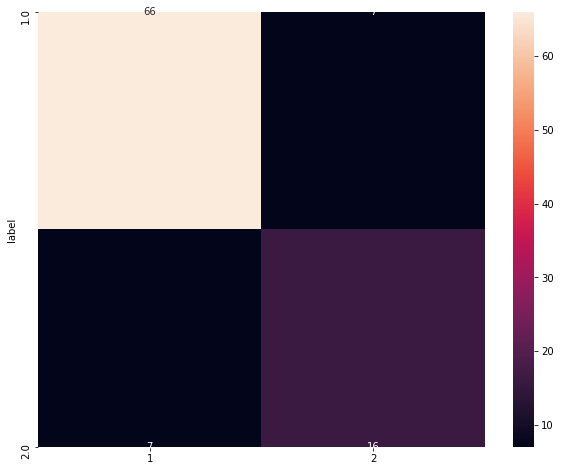

In [29]:
# basic imports

import matplotlib.pyplot as plt
import seaborn as sn

cm_pd = cm.toPandas()
# print(cm_pd)
cm_pd = cm_pd.set_index('label')  # make 'label' as index
# print(cm_pd)

plt.figure(figsize = (10,8))
sn.heatmap(cm_pd, annot=True,fmt='d');

## Step 10 - Experiment
Try the following :
- increase number of hidden layers (3 --> 4 --> 5)
- you can also adjust the number of neurons on each 

See if you can improve the accuracy and confusion matrix.